In [1]:
import torch
import torch.utils
import torch.utils.data
from tqdm.auto import tqdm
from torch import nn
import argparse
import torch.nn.functional as F
import utils
import dataset
import os
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

/home/raunak/miniconda3/envs/cs726env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np

dataPath = 'data/albatross.npy'
data = np.load(dataPath)
print(data.shape)

(32561, 16, 4)


In [3]:
dataPath2 = 'data/albatross_prior_samples.npy'
data2 = np.load(dataPath2)
print(data2.shape)

(32561, 64)


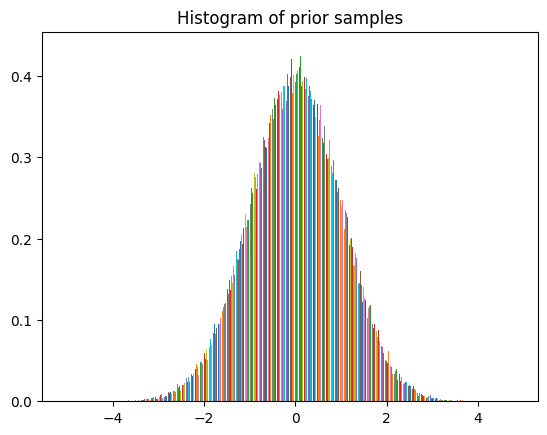

In [4]:
# Make a histogram of the prior sample data
plt.hist(data2, bins=100, density=True)
plt.title('Histogram of prior samples')
plt.show()

In [5]:
moonDataX, moonDataY = dataset.load_dataset('moons')
print(type(moonDataX))
print(moonDataX.shape)
print(type(moonDataY))
print(moonDataY.shape)

<class 'torch.Tensor'>
torch.Size([8000, 2])
<class 'torch.Tensor'>
torch.Size([8000])


In [6]:
# Define the time embedding class to generate sinusoidal embeddings
class TimeEmbedding(nn.Module):
    def __init__(self, numDim : int):
        super().__init__()
        self.numDim = numDim

    def forward(self, time : torch.Tensor):
        '''
        Input:
            time: (batchSize, 1)
        Output:
            embedding: (batchSize, numDim)
        '''
        # Generate the sinusoidal embeddings
        embedding = torch.zeros(time.shape[0], self.numDim)
        for i in range(self.numDim):
            if i % 2 == 0:
                embedding[:, i] = torch.sin(time / 10000 ** (i / self.numDim))
            else:
                embedding[:, i] = torch.cos(time / 10000 ** ((i - 1) / self.numDim))
        return embedding


In [7]:
# Test the time embedding class to generate sinusoidal embeddings
timeEmbedding = TimeEmbedding(10)
timeSteps = torch.arange(0, 100)
print(timeSteps.shape)
embeddings = timeEmbedding(timeSteps)
print(embeddings.shape)
print(embeddings[2, :])

torch.Size([100])
torch.Size([100, 10])
tensor([ 0.9093, -0.4161,  0.3117,  0.9502,  0.0502,  0.9987,  0.0080,  1.0000,
         0.0013,  1.0000])


In [8]:
# Write the Noise Scheduler class that will be used for training the DDPM Model
class NoiseScheduler():
    """
    Noise scheduler for the DDPM model

    Args:
        num_timesteps: int, the number of timesteps
        type: str, the type of scheduler to use
        **kwargs: additional arguments for the scheduler

    This object sets up all the constants like alpha, beta, sigma, etc. required for the DDPM model
    
    """
    def __init__(self, num_timesteps=50, type="linear", **kwargs):

        self.num_timesteps = num_timesteps
        self.type = type

        if type == "linear":
            self.init_linear_schedule(**kwargs)
        else:
            raise NotImplementedError(f"{type} scheduler is not implemented") # change this if you implement additional schedulers


    def init_linear_schedule(self, beta_start, beta_end):
        """
        Precompute whatever quantities are required for training and sampling
        """
        self.betaSchedule = torch.linspace(beta_start, beta_end, self.num_timesteps)
        self.alpha = 1 - self.betaSchedule
        self.alphaProd = torch.cumprod(self.alpha, 0)
        self.sqrtCumprodAlpha = np.sqrt(self.alphaProd)
        self.sqrtAlpha = np.sqrt(self.alpha)
        self.sqrtOneMinusAlpha = np.sqrt(1 - self.alpha)
        self.sqrtOneMinusAlphaProd = torch.sqrt(1 - self.alphaProd)

    def __len__(self):
        return self.num_timesteps

In [9]:
noiseScheduler = NoiseScheduler(num_timesteps=50, 
                                type="linear", 
                                beta_start=0.0001, 
                                beta_end=0.02)
# print(noiseScheduler.betaSchedule)
print(noiseScheduler.alpha)

tensor([0.9999, 0.9995, 0.9991, 0.9987, 0.9983, 0.9979, 0.9975, 0.9971, 0.9967,
        0.9962, 0.9958, 0.9954, 0.9950, 0.9946, 0.9942, 0.9938, 0.9934, 0.9930,
        0.9926, 0.9922, 0.9918, 0.9914, 0.9910, 0.9906, 0.9902, 0.9897, 0.9893,
        0.9889, 0.9885, 0.9881, 0.9877, 0.9873, 0.9869, 0.9865, 0.9861, 0.9857,
        0.9853, 0.9849, 0.9845, 0.9841, 0.9837, 0.9832, 0.9828, 0.9824, 0.9820,
        0.9816, 0.9812, 0.9808, 0.9804, 0.9800])


In [10]:
class MLPModel(nn.Module):
    def __init__(self, inputDim : int, timeEmbedDim : int, hiddenDim : int = 128):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim
        self.fc1 = nn.Linear(inputDim + timeEmbedDim, hiddenDim // 2)
        self.fc2 = nn.Linear(hiddenDim // 2, hiddenDim)
        self.fc3 = nn.Linear(hiddenDim, hiddenDim)
        self.fc4 = nn.Linear(hiddenDim, hiddenDim // 2)
        self.fc5 = nn.Linear(hiddenDim // 2, inputDim)
        self.activation = nn.ReLU()
    
    def forward(self, input : torch.Tensor) -> torch.Tensor:
        '''
        Input:
            input: (batchSize, inputDim)
        Output:
            output: (batchSize, inputDim)
        '''
        output = self.fc1(input)
        output = self.activation(output)
        output = self.fc2(output)
        output = self.activation(output)
        output = self.fc3(output)
        output = self.activation(output)
        output = self.fc4(output)
        output = self.activation(output)
        output = self.fc5(output)
        return output


In [11]:
class AdvancedMLPModel(nn.Module):
    def __init__(self, inputDim: int, timeEmbedDim: int, hiddenDim: int = 256):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim
        # Keep the rest of the model same, change the activation function to SiLU
        self.fc1 = nn.Linear(inputDim + timeEmbedDim, hiddenDim // 2)
        self.fc2 = nn.Linear(hiddenDim // 2, hiddenDim)
        self.fc3 = nn.Linear(hiddenDim, hiddenDim)
        self.fc4 = nn.Linear(hiddenDim, hiddenDim // 2)
        self.fc5 = nn.Linear(hiddenDim // 2, inputDim)
        self.activation = nn.SiLU()
    
    def forward(self, input : torch.Tensor) -> torch.Tensor:
        '''
        Input:
            input: (batchSize, inputDim)
        Output:
            output: (batchSize, inputDim)
        '''
        output = self.fc1(input)
        output = self.activation(output)
        output = self.fc2(output)
        output = self.activation(output)
        output = self.fc3(output)
        output = self.activation(output)
        output = self.fc4(output)
        output = self.activation(output)
        output = self.fc5(output)
        return output

        

In [12]:
class ResidualMLPModel(nn.Module):
    def __init__(self, inputDim: int, timeEmbedDim: int, hiddenDim: int = 256):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim

        # Input projection layer
        self.input_proj = nn.Linear(inputDim + timeEmbedDim, hiddenDim)

        # Main network with residual blocks
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hiddenDim, hiddenDim),  # Concatenate time embedding
                nn.SiLU(),
                nn.Linear(hiddenDim, hiddenDim)
            )
            for _ in range(4)  # Number of residual blocks
        ])

        # Output projection layer
        self.output_proj = nn.Linear(hiddenDim, inputDim)

    def forward(self, x):
        """
        Forward pass of the model.
        Args:
            x: Input tensor of shape (batch_size, inputDim)
            time: Time tensor of shape (batch_size, 1)
        Returns:
            Output tensor of shape (batch_size, inputDim)
        """
        # Time embedding
        # time_embed = self.time_embed(time)  # (batch_size, timeEmbedDim)

        # Input projection
        h = self.input_proj(x)  # (batch_size, hiddenDim)

        # Residual blocks
        for block in self.residual_blocks:
            # Concatenate time embedding
            # h_input = torch.cat([h, time_embed], dim=-1)  # (batch_size, hiddenDim + timeEmbedDim)
            # Residual connection
            h = h + block(h)  # (batch_size, hiddenDim)

        # Output projection
        out = self.output_proj(h)  # (batch_size, inputDim)

        return out

In [13]:
class DDPM(nn.Module):
    def __init__(self, n_dim=3, n_steps=200):
        """
        Noise prediction network for the DDPM

        Args:
            n_dim: int, the dimensionality of the data
            n_steps: int, the number of steps in the diffusion process
        We have separate learnable modules for `time_embed` and `model`. `time_embed` can be learned or a fixed function as well

        """
        super().__init__()
        self.n_dim = n_dim
        self.n_steps = n_steps
        self.time_embed_dim = n_dim
        self.time_embed = TimeEmbedding(self.time_embed_dim)
        # self.model = MLPModel(n_dim, self.time_embed_dim)
        # self.model = AdvancedMLPModel(n_dim, self.time_embed_dim)
        self.model = ResidualMLPModel(n_dim, self.time_embed_dim)

    def forward(self, x, t):
        """
        Args:
            x: torch.Tensor, the input data tensor [batch_size, n_dim]
            t: torch.Tensor, the timestep tensor [batch_size]

        Returns:
            torch.Tensor, the predicted noise tensor [batch_size, n_dim]
        """
        # Get the time embeddings
        timeEmbeddings = self.time_embed(t)
        # Concatenate the input data with the time embeddings
        input = torch.cat([x, timeEmbeddings], dim=-1)
        # Get the predicted noise
        noise = self.model(input)
        return noise

In [14]:
class ConditionalMLPModel(nn.Module):
    def __init__(self, inputDim : int, numClasses: int, timeEmbedDim : int, hiddenDim : int = 128):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim
        self.numClasses = numClasses
        self.fc1 = nn.Linear(inputDim + timeEmbedDim + numClasses, hiddenDim // 2)
        self.fc2 = nn.Linear(hiddenDim // 2, hiddenDim)
        self.fc3 = nn.Linear(hiddenDim, hiddenDim)
        self.fc4 = nn.Linear(hiddenDim, hiddenDim // 2)
        self.fc5 = nn.Linear(hiddenDim // 2, inputDim)
        self.activation = nn.ReLU()
    
    def forward(self, input : torch.Tensor) -> torch.Tensor:
        '''
        Input:
            input: (batchSize, inputDim)
        Output:
            output: (batchSize, inputDim)
        '''
        output = self.fc1(input)
        output = self.activation(output)
        output = self.fc2(output)
        output = self.activation(output)
        output = self.fc3(output)
        output = self.activation(output)
        output = self.fc4(output)
        output = self.activation(output)
        output = self.fc5(output)
        return output

In [15]:
# Define a test model
# ddpm = DDPM(n_dim=3, n_steps=200)
ddpm = DDPM(n_dim=3, n_steps=200)
x = torch.randn(10, 3)
t = torch.randint(0, 200, (10,))
print(x.shape)
print(t.shape)
output = ddpm(x, t)
print(output.shape)

torch.Size([10, 3])
torch.Size([10])
torch.Size([10, 3])


In [16]:
def train(model, noise_scheduler, dataloader, optimizer, epochs, run_name):
    """
    Train the model and save the model and necessary plots

    Args:
        model: DDPM, model to train
        noise_scheduler: NoiseScheduler, scheduler for the noise
        dataloader: torch.utils.data.DataLoader, dataloader for the dataset
        optimizer: torch.optim.Optimizer, optimizer to use
        epochs: int, number of epochs to train the model
        run_name: str, path to save the model
    """
    model.train()
    lossFunction = nn.MSELoss()
    device = next(model.parameters()).device
    for epoch in range(epochs):
        epochLoss = 0
        for x in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x = x.to(device)
            # Define the random time step
            timesteps = torch.randint(0, noise_scheduler.num_timesteps, 
                                      (x.shape[0],), device=device)
            # Get the noise
            noise = torch.randn_like(x)
            noisyInput = (noise_scheduler.sqrtCumprodAlpha[timesteps, None] * x 
                          + noise_scheduler.sqrtOneMinusAlphaProd[timesteps, None] * noise)
            optimizer.zero_grad()
            predictedNoise = model(noisyInput, timesteps)
            loss = lossFunction(predictedNoise, noise)
            loss.backward()
            optimizer.step()
            epochLoss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Loss: {epochLoss/len(dataloader)}")
    torch.save(model.state_dict(), f'models/{run_name}.pth')

In [17]:
print(moonDataX.shape)

torch.Size([8000, 2])


In [18]:
# Define the dataset and dataloader
batchSize = 64
n_steps = 200
dataset = moonDataX
n_dim = dataset.shape[1]
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batchSize, 
                                         shuffle=True)
# Define the model
ddpm = DDPM(n_dim=n_dim, n_steps=n_steps)
# Define the optimizer
optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-3)
# Train the model
train(ddpm, noiseScheduler, 
      dataloader, optimizer, epochs=100, 
      run_name="moon_test1")

Epoch 1/100:   0%|          | 0/125 [00:00<?, ?it/s]/home/raunak/miniconda3/envs/cs726env/lib/python3.8/site-packages/torch/autograd/graph.py:769: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/100: 100%|██████████| 125/125 [00:01<00:00, 70.59it/s] 


Epoch 1/100 Loss: 0.7311272158622741


Epoch 2/100: 100%|██████████| 125/125 [00:00<00:00, 209.12it/s]


Epoch 2/100 Loss: 0.7130211029052734


Epoch 3/100: 100%|██████████| 125/125 [00:00<00:00, 207.60it/s]


Epoch 3/100 Loss: 0.6897420647144318


Epoch 4/100: 100%|██████████| 125/125 [00:00<00:00, 210.86it/s]


Epoch 4/100 Loss: 0.6555682227611542


Epoch 5/100: 100%|██████████| 125/125 [00:00<00:00, 208.11it/s]


Epoch 5/100 Loss: 0.6527907180786133


Epoch 6/100: 100%|██████████| 125/125 [00:00<00:00, 214.45it/s]


Epoch 6/100 Loss: 0.6592640392780303


Epoch 7/100: 100%|██████████| 125/125 [00:00<00:00, 216.87it/s]


Epoch 7/100 Loss: 0.6315570275783539


Epoch 8/100: 100%|██████████| 125/125 [00:00<00:00, 208.78it/s]


Epoch 8/100 Loss: 0.6536358563899994


Epoch 9/100: 100%|██████████| 125/125 [00:00<00:00, 217.84it/s]


Epoch 9/100 Loss: 0.6367847580909729


Epoch 10/100: 100%|██████████| 125/125 [00:00<00:00, 216.44it/s]


Epoch 10/100 Loss: 0.6546675431728363


Epoch 11/100: 100%|██████████| 125/125 [00:00<00:00, 211.60it/s]


Epoch 11/100 Loss: 0.6426128306388855


Epoch 12/100: 100%|██████████| 125/125 [00:00<00:00, 220.70it/s]


Epoch 12/100 Loss: 0.653552460193634


Epoch 13/100: 100%|██████████| 125/125 [00:00<00:00, 219.96it/s]


Epoch 13/100 Loss: 0.6335630483627319


Epoch 14/100: 100%|██████████| 125/125 [00:00<00:00, 218.07it/s]


Epoch 14/100 Loss: 0.6518243799209594


Epoch 15/100: 100%|██████████| 125/125 [00:00<00:00, 222.17it/s]


Epoch 15/100 Loss: 0.6282746560573578


Epoch 16/100: 100%|██████████| 125/125 [00:00<00:00, 221.53it/s]


Epoch 16/100 Loss: 0.6402277555465699


Epoch 17/100: 100%|██████████| 125/125 [00:00<00:00, 221.21it/s]


Epoch 17/100 Loss: 0.6501304926872253


Epoch 18/100: 100%|██████████| 125/125 [00:00<00:00, 222.08it/s]


Epoch 18/100 Loss: 0.6431431405544281


Epoch 19/100: 100%|██████████| 125/125 [00:00<00:00, 221.91it/s]


Epoch 19/100 Loss: 0.6362601463794708


Epoch 20/100: 100%|██████████| 125/125 [00:00<00:00, 217.22it/s]


Epoch 20/100 Loss: 0.6359795355796813


Epoch 21/100: 100%|██████████| 125/125 [00:00<00:00, 220.09it/s]


Epoch 21/100 Loss: 0.6412531168460845


Epoch 22/100: 100%|██████████| 125/125 [00:00<00:00, 213.26it/s]


Epoch 22/100 Loss: 0.6342776043415069


Epoch 23/100: 100%|██████████| 125/125 [00:00<00:00, 211.67it/s]


Epoch 23/100 Loss: 0.629871812582016


Epoch 24/100: 100%|██████████| 125/125 [00:00<00:00, 218.29it/s]


Epoch 24/100 Loss: 0.6421451075077057


Epoch 25/100: 100%|██████████| 125/125 [00:00<00:00, 222.02it/s]


Epoch 25/100 Loss: 0.6477730314731598


Epoch 26/100: 100%|██████████| 125/125 [00:00<00:00, 213.66it/s]


Epoch 26/100 Loss: 0.6353309545516967


Epoch 27/100: 100%|██████████| 125/125 [00:00<00:00, 212.22it/s]


Epoch 27/100 Loss: 0.6440661127567291


Epoch 28/100: 100%|██████████| 125/125 [00:00<00:00, 224.60it/s]


Epoch 28/100 Loss: 0.6287445907592774


Epoch 29/100: 100%|██████████| 125/125 [00:00<00:00, 223.13it/s]


Epoch 29/100 Loss: 0.615889068365097


Epoch 30/100: 100%|██████████| 125/125 [00:00<00:00, 220.69it/s]


Epoch 30/100 Loss: 0.6376161646842956


Epoch 31/100: 100%|██████████| 125/125 [00:00<00:00, 220.33it/s]


Epoch 31/100 Loss: 0.6258305678367615


Epoch 32/100: 100%|██████████| 125/125 [00:00<00:00, 211.91it/s]


Epoch 32/100 Loss: 0.6245545301437377


Epoch 33/100: 100%|██████████| 125/125 [00:00<00:00, 218.83it/s]


Epoch 33/100 Loss: 0.6370862970352172


Epoch 34/100: 100%|██████████| 125/125 [00:00<00:00, 219.52it/s]


Epoch 34/100 Loss: 0.6312994427680969


Epoch 35/100: 100%|██████████| 125/125 [00:00<00:00, 218.46it/s]


Epoch 35/100 Loss: 0.6260551261901856


Epoch 36/100: 100%|██████████| 125/125 [00:00<00:00, 218.42it/s]


Epoch 36/100 Loss: 0.62317649269104


Epoch 37/100: 100%|██████████| 125/125 [00:00<00:00, 216.83it/s]


Epoch 37/100 Loss: 0.6327867984771729


Epoch 38/100: 100%|██████████| 125/125 [00:00<00:00, 223.82it/s]


Epoch 38/100 Loss: 0.6299092657566071


Epoch 39/100: 100%|██████████| 125/125 [00:00<00:00, 221.61it/s]


Epoch 39/100 Loss: 0.6331831693649292


Epoch 40/100: 100%|██████████| 125/125 [00:00<00:00, 217.24it/s]


Epoch 40/100 Loss: 0.6475510544776917


Epoch 41/100: 100%|██████████| 125/125 [00:00<00:00, 225.25it/s]


Epoch 41/100 Loss: 0.6198415689468384


Epoch 42/100: 100%|██████████| 125/125 [00:00<00:00, 224.13it/s]


Epoch 42/100 Loss: 0.6192392182350158


Epoch 43/100: 100%|██████████| 125/125 [00:00<00:00, 213.82it/s]


Epoch 43/100 Loss: 0.6229229304790497


Epoch 44/100: 100%|██████████| 125/125 [00:00<00:00, 217.34it/s]


Epoch 44/100 Loss: 0.6190386836528778


Epoch 45/100: 100%|██████████| 125/125 [00:00<00:00, 219.95it/s]


Epoch 45/100 Loss: 0.6300814042091369


Epoch 46/100: 100%|██████████| 125/125 [00:00<00:00, 222.15it/s]


Epoch 46/100 Loss: 0.6215942153930664


Epoch 47/100: 100%|██████████| 125/125 [00:00<00:00, 219.65it/s]


Epoch 47/100 Loss: 0.6210427014827729


Epoch 48/100: 100%|██████████| 125/125 [00:00<00:00, 220.48it/s]


Epoch 48/100 Loss: 0.6101794545650482


Epoch 49/100: 100%|██████████| 125/125 [00:00<00:00, 218.68it/s]


Epoch 49/100 Loss: 0.6170580377578735


Epoch 50/100: 100%|██████████| 125/125 [00:00<00:00, 218.89it/s]


Epoch 50/100 Loss: 0.6106893379688263


Epoch 51/100: 100%|██████████| 125/125 [00:00<00:00, 218.69it/s]


Epoch 51/100 Loss: 0.6277432940006256


Epoch 52/100: 100%|██████████| 125/125 [00:00<00:00, 218.82it/s]


Epoch 52/100 Loss: 0.6083828523159027


Epoch 53/100: 100%|██████████| 125/125 [00:00<00:00, 211.48it/s]


Epoch 53/100 Loss: 0.624718876361847


Epoch 54/100: 100%|██████████| 125/125 [00:00<00:00, 217.80it/s]


Epoch 54/100 Loss: 0.6340716030597687


Epoch 55/100: 100%|██████████| 125/125 [00:00<00:00, 221.37it/s]


Epoch 55/100 Loss: 0.6301309962272644


Epoch 56/100: 100%|██████████| 125/125 [00:00<00:00, 220.84it/s]


Epoch 56/100 Loss: 0.627986356973648


Epoch 57/100: 100%|██████████| 125/125 [00:00<00:00, 222.03it/s]


Epoch 57/100 Loss: 0.627837146282196


Epoch 58/100: 100%|██████████| 125/125 [00:00<00:00, 225.55it/s]


Epoch 58/100 Loss: 0.6312089157104492


Epoch 59/100: 100%|██████████| 125/125 [00:00<00:00, 222.51it/s]


Epoch 59/100 Loss: 0.6133431346416474


Epoch 60/100: 100%|██████████| 125/125 [00:00<00:00, 219.58it/s]


Epoch 60/100 Loss: 0.6255962898731232


Epoch 61/100: 100%|██████████| 125/125 [00:00<00:00, 215.58it/s]


Epoch 61/100 Loss: 0.6298000497817993


Epoch 62/100: 100%|██████████| 125/125 [00:00<00:00, 218.49it/s]


Epoch 62/100 Loss: 0.6388582849502563


Epoch 63/100: 100%|██████████| 125/125 [00:00<00:00, 219.46it/s]


Epoch 63/100 Loss: 0.6217259867191315


Epoch 64/100: 100%|██████████| 125/125 [00:00<00:00, 218.11it/s]


Epoch 64/100 Loss: 0.6267442710399628


Epoch 65/100: 100%|██████████| 125/125 [00:00<00:00, 222.11it/s]


Epoch 65/100 Loss: 0.6167870945930481


Epoch 66/100: 100%|██████████| 125/125 [00:00<00:00, 221.85it/s]


Epoch 66/100 Loss: 0.6272541131973267


Epoch 67/100: 100%|██████████| 125/125 [00:00<00:00, 220.65it/s]


Epoch 67/100 Loss: 0.6248371999263763


Epoch 68/100: 100%|██████████| 125/125 [00:00<00:00, 218.64it/s]


Epoch 68/100 Loss: 0.623759595155716


Epoch 69/100: 100%|██████████| 125/125 [00:00<00:00, 219.05it/s]


Epoch 69/100 Loss: 0.6145726311206817


Epoch 70/100: 100%|██████████| 125/125 [00:00<00:00, 220.56it/s]


Epoch 70/100 Loss: 0.6225975675582885


Epoch 71/100: 100%|██████████| 125/125 [00:00<00:00, 217.94it/s]


Epoch 71/100 Loss: 0.6355658490657806


Epoch 72/100: 100%|██████████| 125/125 [00:00<00:00, 217.29it/s]


Epoch 72/100 Loss: 0.6187913579940796


Epoch 73/100: 100%|██████████| 125/125 [00:00<00:00, 213.77it/s]


Epoch 73/100 Loss: 0.630121707201004


Epoch 74/100: 100%|██████████| 125/125 [00:00<00:00, 213.55it/s]


Epoch 74/100 Loss: 0.6071233186721802


Epoch 75/100: 100%|██████████| 125/125 [00:00<00:00, 213.13it/s]


Epoch 75/100 Loss: 0.6200942792892457


Epoch 76/100: 100%|██████████| 125/125 [00:00<00:00, 217.75it/s]


Epoch 76/100 Loss: 0.6177521934509277


Epoch 77/100: 100%|██████████| 125/125 [00:00<00:00, 217.30it/s]


Epoch 77/100 Loss: 0.6183233499526978


Epoch 78/100: 100%|██████████| 125/125 [00:00<00:00, 218.25it/s]


Epoch 78/100 Loss: 0.6239023721218109


Epoch 79/100: 100%|██████████| 125/125 [00:00<00:00, 212.62it/s]


Epoch 79/100 Loss: 0.6193956174850463


Epoch 80/100: 100%|██████████| 125/125 [00:00<00:00, 212.25it/s]


Epoch 80/100 Loss: 0.6238119661808014


Epoch 81/100: 100%|██████████| 125/125 [00:00<00:00, 213.53it/s]


Epoch 81/100 Loss: 0.6193039712905883


Epoch 82/100: 100%|██████████| 125/125 [00:00<00:00, 210.37it/s]


Epoch 82/100 Loss: 0.6197189221382141


Epoch 83/100: 100%|██████████| 125/125 [00:00<00:00, 215.19it/s]


Epoch 83/100 Loss: 0.6153831551074982


Epoch 84/100: 100%|██████████| 125/125 [00:00<00:00, 219.96it/s]


Epoch 84/100 Loss: 0.6301111748218536


Epoch 85/100: 100%|██████████| 125/125 [00:00<00:00, 218.38it/s]


Epoch 85/100 Loss: 0.626918683052063


Epoch 86/100: 100%|██████████| 125/125 [00:00<00:00, 221.25it/s]


Epoch 86/100 Loss: 0.6235763263702393


Epoch 87/100: 100%|██████████| 125/125 [00:00<00:00, 223.24it/s]


Epoch 87/100 Loss: 0.6223541021347045


Epoch 88/100: 100%|██████████| 125/125 [00:00<00:00, 218.89it/s]


Epoch 88/100 Loss: 0.6211559226512909


Epoch 89/100: 100%|██████████| 125/125 [00:00<00:00, 218.68it/s]


Epoch 89/100 Loss: 0.6252880821228027


Epoch 90/100: 100%|██████████| 125/125 [00:00<00:00, 217.86it/s]


Epoch 90/100 Loss: 0.6147081043720245


Epoch 91/100: 100%|██████████| 125/125 [00:00<00:00, 214.72it/s]


Epoch 91/100 Loss: 0.6202407751083374


Epoch 92/100: 100%|██████████| 125/125 [00:00<00:00, 217.73it/s]


Epoch 92/100 Loss: 0.6091495647430419


Epoch 93/100: 100%|██████████| 125/125 [00:00<00:00, 218.92it/s]


Epoch 93/100 Loss: 0.6257408442497253


Epoch 94/100: 100%|██████████| 125/125 [00:00<00:00, 220.55it/s]


Epoch 94/100 Loss: 0.631190952539444


Epoch 95/100: 100%|██████████| 125/125 [00:00<00:00, 210.17it/s]


Epoch 95/100 Loss: 0.6352707278728486


Epoch 96/100: 100%|██████████| 125/125 [00:00<00:00, 220.14it/s]


Epoch 96/100 Loss: 0.6117376911640168


Epoch 97/100: 100%|██████████| 125/125 [00:00<00:00, 220.87it/s]


Epoch 97/100 Loss: 0.6135833976268769


Epoch 98/100: 100%|██████████| 125/125 [00:00<00:00, 223.33it/s]


Epoch 98/100 Loss: 0.6261517553329468


Epoch 99/100: 100%|██████████| 125/125 [00:00<00:00, 220.13it/s]


Epoch 99/100 Loss: 0.6098615338802338


Epoch 100/100: 100%|██████████| 125/125 [00:00<00:00, 219.52it/s]

Epoch 100/100 Loss: 0.6208547921180725


In [19]:
@torch.no_grad()
def sample(model, n_samples, noise_scheduler, return_intermediate=False):
    """
    Sample from the model
    
    Args:
        model: DDPM
        n_samples: int
        noise_scheduler: NoiseScheduler
        return_intermediate: bool
    Returns:
        torch.Tensor, samples from the model [n_samples, n_dim]

    If `return_intermediate` is `False`,
            torch.Tensor, samples from the model [n_samples, n_dim]
    Else
        the function returns all the intermediate steps in the diffusion process as well 
        Return: [[n_samples, n_dim]] x n_steps
        Optionally implement return_intermediate=True, will aid in visualizing the intermediate steps
    """  
    device = next(model.parameters()).device
    model.eval()
    samples = [] if return_intermediate else None
    numDim = model.model.inputDim
    inputs = torch.randn(n_samples, numDim, device=device)

    for timestep in reversed(range(0, noise_scheduler.num_timesteps)):
        timesteps = torch.full((n_samples,), timestep, device=device)
        noisePred = model(inputs, timesteps)
        inputs = ((inputs - ((1.0 - noise_scheduler.alpha[timestep]) / noise_scheduler.sqrtOneMinusAlphaProd[timestep]) * noisePred)
                  / noise_scheduler.sqrtAlpha[timestep])
        if return_intermediate:
            samples.append(inputs.clone().cpu().numpy())
    if return_intermediate:
        return samples
    return inputs

    

In [20]:
# Test the sampling function
trainedModel = DDPM(n_dim=2, n_steps=200)
trainedModel.load_state_dict(torch.load('models/moon_test1.pth'))
# trainedModel.eval()
samples = sample(trainedModel, 8000, noiseScheduler, 
                 return_intermediate=True)
# print(samples.shape)

/tmp/ipykernel_18689/1447921429.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainedModel.load_state_dict(torch.load('models/moon_test1.pth'))


In [21]:
print(len(samples))
from utils import animateScatter2d
from IPython.display import HTML

figure, axes = plt.subplots(1, 1, figsize=(10, 10))
animation = animateScatter2d(figure, axes, samples, title="Diffusion Process")
plt.close()
display(HTML(animation.to_html5_video()))

50


In [22]:
print(samples[0])

[[ 0.18012346  0.08806113]
 [-0.40488538 -0.24970071]
 [ 0.71706825  0.55236506]
 ...
 [ 0.5310798  -0.95641816]
 [-1.3946096   0.37597588]
 [-0.03996717  0.34238815]]


In [23]:
# Modified Conditional DDPM that supports classifier-free guidance
class ConditionalDDPM(nn.Module):
    def __init__(self, n_dim=3, n_steps=200, n_classes=2):
        """
        Conditional Noise Prediction Network for DDPM with support for classifier-free guidance.
        
        Args:
            n_dim: int, dimensionality of the data
            n_steps: int, number of diffusion steps
            n_classes: int, number of classes (used for conditional generation)
        """
        super().__init__()
        self.n_dim = n_dim
        self.n_steps = n_steps
        self.time_embed_dim = n_dim
        # We use a class embedding of the same size as the data dimension
        self.class_embed_dim = n_dim
        self.time_embed = TimeEmbedding(self.time_embed_dim)
        self.class_embed = nn.Embedding(n_classes, n_dim)
        self.model = ConditionalMLPModel(n_dim, self.time_embed_dim, self.class_embed_dim)
    
    def forward(self, x, t, y=None):
        """
        Args:
            x: torch.Tensor, input data [batch_size, n_dim]
            t: torch.Tensor, timesteps [batch_size]
            y: torch.Tensor or None, class labels [batch_size] or None for unconditional
        Returns:
            torch.Tensor, predicted noise [batch_size, n_dim]
        """
        timeEmbeddings = self.time_embed(t)
        if y is None:
            # For unconditional prediction, use a zero vector as the class embedding.
            classEmbeddings = torch.zeros(x.size(0), self.n_dim, device=x.device)
        else:
            classEmbeddings = self.class_embed(y)
        # Concatenate data, class embedding, and time embedding.
        inp = torch.cat([x, classEmbeddings, timeEmbeddings], dim=-1)
        noise = self.model(inp)
        return noise


In [24]:

def trainConditional(model, noise_scheduler, dataloader, optimizer, epochs, run_name, cond_dropout=0.2):
    """
    Train the conditional model with classifier-free guidance.
    
    Args:
        model: ConditionalDDPM, the model to train.
        noise_scheduler: NoiseScheduler, provides noise schedule parameters.
        dataloader: torch.utils.data.DataLoader, training data.
        optimizer: torch.optim.Optimizer, optimizer.
        epochs: int, number of epochs.
        run_name: str, name used for saving the trained model.
        cond_dropout: float, probability to drop the condition (simulate unconditional training).
    """
    # Move noise scheduler tensors to the correct device
    device = torch.device("cpu")
    noise_scheduler.sqrtCumprodAlpha = noise_scheduler.sqrtCumprodAlpha.to(device)
    noise_scheduler.sqrtOneMinusAlphaProd = noise_scheduler.sqrtOneMinusAlphaProd.to(device)
    noise_scheduler.sqrtAlpha = noise_scheduler.sqrtAlpha.to(device)
    noise_scheduler.alpha = noise_scheduler.alpha.to(device)

    model.train()
    lossFunction = nn.MSELoss()
    for epoch in range(epochs):
        epochLoss = 0
        for x, y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x = x.to(device)
            y = y.to(device)
            # Random timesteps for each sample.
            timesteps = torch.randint(0, noise_scheduler.num_timesteps, (x.shape[0],), device=device)
            noise = torch.randn_like(x)
            noisyInput = (noise_scheduler.sqrtCumprodAlpha[timesteps, None] * x +
                          noise_scheduler.sqrtOneMinusAlphaProd[timesteps, None] * noise)
            optimizer.zero_grad()
            # With probability cond_dropout, drop the condition.
            if torch.rand(1).item() < cond_dropout:
                y_input = None
            else:
                y_input = y
            predictedNoise = model(noisyInput, timesteps, y_input)
            loss = lossFunction(predictedNoise, noise)
            loss.backward()
            optimizer.step()
            epochLoss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Loss: {epochLoss/len(dataloader)}")
    torch.save(model.state_dict(), f'models/{run_name}.pth')

@torch.no_grad()
def sampleConditional(model, n_samples, noise_scheduler, class_label: int, guidance_scale=0.0, return_intermediate=False):
    """
    Sample from the model using classifier-free guidance for a fixed class label.
    
    Args:
        model: ConditionalDDPM, the trained model.
        n_samples: int, number of samples to generate.
        noise_scheduler: NoiseScheduler, provides the noise schedule parameters.
        class_label: int, fixed class label for conditioning.
        guidance_scale: float, guidance strength (set >0 to steer sampling).
        return_intermediate: bool, if True returns all intermediate denoising steps.
    
    Returns:
        torch.Tensor of shape [n_samples, n_dim] with generated samples, or
        a list of intermediate steps if return_intermediate=True.
    """
    device = torch.device("cpu")
    model.eval()
    numDim = model.n_dim
    inputs = torch.randn(n_samples, numDim, device=device)
    # Use a fixed class label for all samples
    y = torch.full((n_samples,), class_label, dtype=torch.long, device=device)

    samples = [] if return_intermediate else None

    for timestep in reversed(range(noise_scheduler.num_timesteps)):
        timesteps = torch.full((n_samples,), timestep, device=device)
        if guidance_scale != 0.0:
            # Get unconditional prediction (simulate dropping the condition)
            unconditional_noise = model(inputs, timesteps, None)
            # Get conditional prediction
            conditional_noise = model(inputs, timesteps, y)
            # Combine the two predictions using the guidance formula
            noisePred = (1 + guidance_scale) * conditional_noise - guidance_scale * unconditional_noise
        else:
            noisePred = model(inputs, timesteps, y)
        
        # Update the denoising step using the noise scheduler parameters
        inputs = ((inputs - ((1.0 - noise_scheduler.alpha[timestep]) / 
                  noise_scheduler.sqrtOneMinusAlphaProd[timestep]) * noisePred)
                  / noise_scheduler.sqrtAlpha[timestep])
        if return_intermediate:
            samples.append(inputs.clone().cpu().numpy())
    if return_intermediate:
        return samples
    return inputs
    return inputs



In [25]:
# ====== Define a simple classifier for evaluating generated samples ======
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def trainClassifier(classifier, x_train, y_train, epochs=50, batch_size=32, lr=1e-3):
    classifier.train()
    optimizer = optim.Adam(classifier.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    dataset = list(zip(x_train, y_train))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        epoch_loss = 0
        for x_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = classifier(x_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Classifier Epoch {epoch+1}/{epochs} Loss: {epoch_loss/len(dataloader):.4f}")
    return classifier

def evaluateClassifier(classifier, x, y):
    classifier.eval()
    with torch.no_grad():
        outputs = classifier(x)
        preds = outputs.argmax(dim=1)
        accuracy = (preds == y).float().mean().item()
    print(f"Classifier accuracy on real data: {accuracy*100:.2f}%")
    return accuracy

# ====== Assuming moonDataX and moonDataY are available and are torch.Tensors ======
# (e.g. moonDataX shape: [num_samples, 2], moonDataY shape: [num_samples])

# Define hyperparameters and device
batchSize = 64
device = torch.device("cpu")

# ====== Prepare DataLoader for training the conditional DDPM ======
x = moonDataX.to(device)  # Data tensor [num_samples, 2]
y = moonDataY.to(device)  # Labels tensor [num_samples]
t = torch.randint(0, 200, (moonDataX.shape[0],), device=device)
print("x:", x.shape, "t:", t.shape, "y:", y.shape)
dataloader = DataLoader(list(zip(x, y)), batch_size=batchSize, shuffle=True)

# ====== Train the simple classifier on the real data ======
classifier = SimpleClassifier(input_dim=2, num_classes=2).to(device)
classifier = trainClassifier(classifier, x, y, epochs=50, batch_size=batchSize, lr=1e-3)

# ====== Evaluate the classifier on real data ======
evaluateClassifier(classifier, x, y)

x: torch.Size([8000, 2]) t: torch.Size([8000]) y: torch.Size([8000])
Classifier Epoch 1/50 Loss: 0.3822
Classifier Epoch 2/50 Loss: 0.2311
Classifier Epoch 3/50 Loss: 0.1935
Classifier Epoch 4/50 Loss: 0.1602
Classifier Epoch 5/50 Loss: 0.1282
Classifier Epoch 6/50 Loss: 0.0994
Classifier Epoch 7/50 Loss: 0.0758
Classifier Epoch 8/50 Loss: 0.0579
Classifier Epoch 9/50 Loss: 0.0448
Classifier Epoch 10/50 Loss: 0.0352
Classifier Epoch 11/50 Loss: 0.0281
Classifier Epoch 12/50 Loss: 0.0227
Classifier Epoch 13/50 Loss: 0.0186
Classifier Epoch 14/50 Loss: 0.0155
Classifier Epoch 15/50 Loss: 0.0131
Classifier Epoch 16/50 Loss: 0.0111
Classifier Epoch 17/50 Loss: 0.0095
Classifier Epoch 18/50 Loss: 0.0082
Classifier Epoch 19/50 Loss: 0.0071
Classifier Epoch 20/50 Loss: 0.0063
Classifier Epoch 21/50 Loss: 0.0055
Classifier Epoch 22/50 Loss: 0.0049
Classifier Epoch 23/50 Loss: 0.0043
Classifier Epoch 24/50 Loss: 0.0039
Classifier Epoch 25/50 Loss: 0.0034
Classifier Epoch 26/50 Loss: 0.0031
Clas

1.0

In [26]:
# ====== Define and train the conditional DDPM ======
conditionalDDPM = ConditionalDDPM(n_dim=2, n_steps=200, n_classes=2).to(device)
optimizer_ddpm = optim.Adam(conditionalDDPM.parameters(), lr=1e-3)
# Assume noiseScheduler is defined and has attributes such as num_timesteps,
# sqrtCumprodAlpha, sqrtOneMinusAlphaProd, sqrtAlpha, and alpha.
trainConditional(conditionalDDPM, noiseScheduler, dataloader, optimizer_ddpm,
                 epochs=100, run_name="moon_test_conditional", cond_dropout=0.1)


Epoch 1/100: 100%|██████████| 125/125 [00:00<00:00, 516.40it/s]


Epoch 1/100 Loss: 0.7017522299289704


Epoch 2/100: 100%|██████████| 125/125 [00:00<00:00, 533.72it/s]


Epoch 2/100 Loss: 0.6012146506309509


Epoch 3/100: 100%|██████████| 125/125 [00:00<00:00, 546.90it/s]


Epoch 3/100 Loss: 0.5550521652698517


Epoch 4/100: 100%|██████████| 125/125 [00:00<00:00, 543.90it/s]


Epoch 4/100 Loss: 0.5489106619358063


Epoch 5/100: 100%|██████████| 125/125 [00:00<00:00, 542.51it/s]


Epoch 5/100 Loss: 0.530585419178009


Epoch 6/100: 100%|██████████| 125/125 [00:00<00:00, 553.50it/s]


Epoch 6/100 Loss: 0.5361190962791443


Epoch 7/100: 100%|██████████| 125/125 [00:00<00:00, 488.78it/s]


Epoch 7/100 Loss: 0.5475022022724152


Epoch 8/100: 100%|██████████| 125/125 [00:00<00:00, 536.50it/s]


Epoch 8/100 Loss: 0.5483060712814332


Epoch 9/100: 100%|██████████| 125/125 [00:00<00:00, 529.93it/s]


Epoch 9/100 Loss: 0.5412393808364868


Epoch 10/100: 100%|██████████| 125/125 [00:00<00:00, 545.06it/s]


Epoch 10/100 Loss: 0.5312057604789734


Epoch 11/100: 100%|██████████| 125/125 [00:00<00:00, 568.65it/s]


Epoch 11/100 Loss: 0.542425418138504


Epoch 12/100: 100%|██████████| 125/125 [00:00<00:00, 571.77it/s]


Epoch 12/100 Loss: 0.526762600183487


Epoch 13/100: 100%|██████████| 125/125 [00:00<00:00, 585.89it/s]


Epoch 13/100 Loss: 0.5281835651397705


Epoch 14/100: 100%|██████████| 125/125 [00:00<00:00, 602.80it/s]


Epoch 14/100 Loss: 0.5258186900615692


Epoch 15/100: 100%|██████████| 125/125 [00:00<00:00, 575.06it/s]


Epoch 15/100 Loss: 0.5195798890590668


Epoch 16/100: 100%|██████████| 125/125 [00:00<00:00, 543.90it/s]


Epoch 16/100 Loss: 0.5277205567359924


Epoch 17/100: 100%|██████████| 125/125 [00:00<00:00, 536.20it/s]


Epoch 17/100 Loss: 0.5260809233188629


Epoch 18/100: 100%|██████████| 125/125 [00:00<00:00, 529.55it/s]


Epoch 18/100 Loss: 0.5314838330745697


Epoch 19/100: 100%|██████████| 125/125 [00:00<00:00, 556.94it/s]


Epoch 19/100 Loss: 0.5348211901187897


Epoch 20/100: 100%|██████████| 125/125 [00:00<00:00, 587.56it/s]


Epoch 20/100 Loss: 0.5275073986053467


Epoch 21/100: 100%|██████████| 125/125 [00:00<00:00, 537.00it/s]


Epoch 21/100 Loss: 0.5159948916435242


Epoch 22/100: 100%|██████████| 125/125 [00:00<00:00, 533.06it/s]


Epoch 22/100 Loss: 0.530968364238739


Epoch 23/100: 100%|██████████| 125/125 [00:00<00:00, 534.05it/s]


Epoch 23/100 Loss: 0.5254449064731598


Epoch 24/100: 100%|██████████| 125/125 [00:00<00:00, 547.03it/s]


Epoch 24/100 Loss: 0.5353096454143524


Epoch 25/100: 100%|██████████| 125/125 [00:00<00:00, 531.43it/s]


Epoch 25/100 Loss: 0.5402630043029785


Epoch 26/100: 100%|██████████| 125/125 [00:00<00:00, 564.73it/s]


Epoch 26/100 Loss: 0.5175522112846375


Epoch 27/100: 100%|██████████| 125/125 [00:00<00:00, 566.01it/s]


Epoch 27/100 Loss: 0.5091282904148102


Epoch 28/100: 100%|██████████| 125/125 [00:00<00:00, 562.33it/s]


Epoch 28/100 Loss: 0.5230841703414917


Epoch 29/100: 100%|██████████| 125/125 [00:00<00:00, 553.65it/s]


Epoch 29/100 Loss: 0.5128952114582062


Epoch 30/100: 100%|██████████| 125/125 [00:00<00:00, 522.85it/s]


Epoch 30/100 Loss: 0.5357926905155181


Epoch 31/100: 100%|██████████| 125/125 [00:00<00:00, 539.74it/s]


Epoch 31/100 Loss: 0.5140143241882325


Epoch 32/100: 100%|██████████| 125/125 [00:00<00:00, 526.13it/s]


Epoch 32/100 Loss: 0.531113481760025


Epoch 33/100: 100%|██████████| 125/125 [00:00<00:00, 495.78it/s]


Epoch 33/100 Loss: 0.5232611091136933


Epoch 34/100: 100%|██████████| 125/125 [00:00<00:00, 516.36it/s]


Epoch 34/100 Loss: 0.5261941151618957


Epoch 35/100: 100%|██████████| 125/125 [00:00<00:00, 524.10it/s]


Epoch 35/100 Loss: 0.5229975814819336


Epoch 36/100: 100%|██████████| 125/125 [00:00<00:00, 525.66it/s]


Epoch 36/100 Loss: 0.5313302092552185


Epoch 37/100: 100%|██████████| 125/125 [00:00<00:00, 534.71it/s]


Epoch 37/100 Loss: 0.5212646973133087


Epoch 38/100: 100%|██████████| 125/125 [00:00<00:00, 536.14it/s]


Epoch 38/100 Loss: 0.5306863985061645


Epoch 39/100: 100%|██████████| 125/125 [00:00<00:00, 534.64it/s]


Epoch 39/100 Loss: 0.5166929991245269


Epoch 40/100: 100%|██████████| 125/125 [00:00<00:00, 537.40it/s]


Epoch 40/100 Loss: 0.5329171364307403


Epoch 41/100: 100%|██████████| 125/125 [00:00<00:00, 542.81it/s]


Epoch 41/100 Loss: 0.5232247700691223


Epoch 42/100: 100%|██████████| 125/125 [00:00<00:00, 565.42it/s]


Epoch 42/100 Loss: 0.527265816450119


Epoch 43/100: 100%|██████████| 125/125 [00:00<00:00, 558.50it/s]


Epoch 43/100 Loss: 0.5182453384399414


Epoch 44/100: 100%|██████████| 125/125 [00:00<00:00, 574.46it/s]


Epoch 44/100 Loss: 0.5309472682476044


Epoch 45/100: 100%|██████████| 125/125 [00:00<00:00, 592.83it/s]


Epoch 45/100 Loss: 0.523693695306778


Epoch 46/100: 100%|██████████| 125/125 [00:00<00:00, 595.33it/s]


Epoch 46/100 Loss: 0.5042781457901001


Epoch 47/100: 100%|██████████| 125/125 [00:00<00:00, 588.30it/s]


Epoch 47/100 Loss: 0.5329026012420655


Epoch 48/100: 100%|██████████| 125/125 [00:00<00:00, 601.10it/s]


Epoch 48/100 Loss: 0.5209217882156372


Epoch 49/100: 100%|██████████| 125/125 [00:00<00:00, 609.41it/s]


Epoch 49/100 Loss: 0.5151339323520661


Epoch 50/100: 100%|██████████| 125/125 [00:00<00:00, 601.68it/s]


Epoch 50/100 Loss: 0.522936799287796


Epoch 51/100: 100%|██████████| 125/125 [00:00<00:00, 599.16it/s]


Epoch 51/100 Loss: 0.5285408725738525


Epoch 52/100: 100%|██████████| 125/125 [00:00<00:00, 602.98it/s]


Epoch 52/100 Loss: 0.5140913894176483


Epoch 53/100: 100%|██████████| 125/125 [00:00<00:00, 600.79it/s]


Epoch 53/100 Loss: 0.5281275222301484


Epoch 54/100: 100%|██████████| 125/125 [00:00<00:00, 604.27it/s]


Epoch 54/100 Loss: 0.5245537180900574


Epoch 55/100: 100%|██████████| 125/125 [00:00<00:00, 576.26it/s]


Epoch 55/100 Loss: 0.5203385605812073


Epoch 56/100: 100%|██████████| 125/125 [00:00<00:00, 602.46it/s]


Epoch 56/100 Loss: 0.5252684335708618


Epoch 57/100: 100%|██████████| 125/125 [00:00<00:00, 597.55it/s]


Epoch 57/100 Loss: 0.5072064230442047


Epoch 58/100: 100%|██████████| 125/125 [00:00<00:00, 584.81it/s]


Epoch 58/100 Loss: 0.5318278217315674


Epoch 59/100: 100%|██████████| 125/125 [00:00<00:00, 589.80it/s]


Epoch 59/100 Loss: 0.5260380520820618


Epoch 60/100: 100%|██████████| 125/125 [00:00<00:00, 583.29it/s]


Epoch 60/100 Loss: 0.5263086836338043


Epoch 61/100: 100%|██████████| 125/125 [00:00<00:00, 494.11it/s]


Epoch 61/100 Loss: 0.5261809961795807


Epoch 62/100: 100%|██████████| 125/125 [00:00<00:00, 548.63it/s]


Epoch 62/100 Loss: 0.5129792275428772


Epoch 63/100: 100%|██████████| 125/125 [00:00<00:00, 552.21it/s]


Epoch 63/100 Loss: 0.5367434785366059


Epoch 64/100: 100%|██████████| 125/125 [00:00<00:00, 526.15it/s]


Epoch 64/100 Loss: 0.5078373947143555


Epoch 65/100: 100%|██████████| 125/125 [00:00<00:00, 531.95it/s]


Epoch 65/100 Loss: 0.5220475883483887


Epoch 66/100: 100%|██████████| 125/125 [00:00<00:00, 527.50it/s]


Epoch 66/100 Loss: 0.5175946755409241


Epoch 67/100: 100%|██████████| 125/125 [00:00<00:00, 539.38it/s]


Epoch 67/100 Loss: 0.5256652593612671


Epoch 68/100: 100%|██████████| 125/125 [00:00<00:00, 534.16it/s]


Epoch 68/100 Loss: 0.5069198744297028


Epoch 69/100: 100%|██████████| 125/125 [00:00<00:00, 532.64it/s]


Epoch 69/100 Loss: 0.5136255402565002


Epoch 70/100: 100%|██████████| 125/125 [00:00<00:00, 530.79it/s]


Epoch 70/100 Loss: 0.532572714805603


Epoch 71/100: 100%|██████████| 125/125 [00:00<00:00, 536.20it/s]


Epoch 71/100 Loss: 0.5249819450378418


Epoch 72/100: 100%|██████████| 125/125 [00:00<00:00, 542.78it/s]


Epoch 72/100 Loss: 0.5331489400863647


Epoch 73/100: 100%|██████████| 125/125 [00:00<00:00, 552.51it/s]


Epoch 73/100 Loss: 0.5151758754253387


Epoch 74/100: 100%|██████████| 125/125 [00:00<00:00, 528.12it/s]


Epoch 74/100 Loss: 0.532638326883316


Epoch 75/100: 100%|██████████| 125/125 [00:00<00:00, 546.95it/s]


Epoch 75/100 Loss: 0.5250408093929291


Epoch 76/100: 100%|██████████| 125/125 [00:00<00:00, 522.26it/s]


Epoch 76/100 Loss: 0.5157368943691254


Epoch 77/100: 100%|██████████| 125/125 [00:00<00:00, 565.23it/s]


Epoch 77/100 Loss: 0.5172495675086975


Epoch 78/100: 100%|██████████| 125/125 [00:00<00:00, 572.62it/s]


Epoch 78/100 Loss: 0.5268702855110169


Epoch 79/100: 100%|██████████| 125/125 [00:00<00:00, 560.57it/s]


Epoch 79/100 Loss: 0.5168656270503997


Epoch 80/100: 100%|██████████| 125/125 [00:00<00:00, 559.80it/s]


Epoch 80/100 Loss: 0.5211695833206177


Epoch 81/100: 100%|██████████| 125/125 [00:00<00:00, 565.79it/s]


Epoch 81/100 Loss: 0.5110664610862732


Epoch 82/100: 100%|██████████| 125/125 [00:00<00:00, 578.94it/s]


Epoch 82/100 Loss: 0.5157494335174561


Epoch 83/100: 100%|██████████| 125/125 [00:00<00:00, 576.44it/s]


Epoch 83/100 Loss: 0.5049726307392121


Epoch 84/100: 100%|██████████| 125/125 [00:00<00:00, 583.21it/s]


Epoch 84/100 Loss: 0.506204418182373


Epoch 85/100: 100%|██████████| 125/125 [00:00<00:00, 578.96it/s]


Epoch 85/100 Loss: 0.520600003004074


Epoch 86/100: 100%|██████████| 125/125 [00:00<00:00, 578.68it/s]


Epoch 86/100 Loss: 0.5098036680221557


Epoch 87/100: 100%|██████████| 125/125 [00:00<00:00, 570.29it/s]


Epoch 87/100 Loss: 0.512878530740738


Epoch 88/100: 100%|██████████| 125/125 [00:00<00:00, 559.98it/s]


Epoch 88/100 Loss: 0.5042087090015411


Epoch 89/100: 100%|██████████| 125/125 [00:00<00:00, 564.28it/s]


Epoch 89/100 Loss: 0.5192176005840301


Epoch 90/100: 100%|██████████| 125/125 [00:00<00:00, 565.44it/s]


Epoch 90/100 Loss: 0.5263028984069824


Epoch 91/100: 100%|██████████| 125/125 [00:00<00:00, 565.15it/s]


Epoch 91/100 Loss: 0.5310173780918122


Epoch 92/100: 100%|██████████| 125/125 [00:00<00:00, 559.62it/s]


Epoch 92/100 Loss: 0.5175066163539886


Epoch 93/100: 100%|██████████| 125/125 [00:00<00:00, 574.55it/s]


Epoch 93/100 Loss: 0.5157553052902222


Epoch 94/100: 100%|██████████| 125/125 [00:00<00:00, 570.23it/s]


Epoch 94/100 Loss: 0.5147672998905182


Epoch 95/100: 100%|██████████| 125/125 [00:00<00:00, 583.57it/s]


Epoch 95/100 Loss: 0.5089104566574096


Epoch 96/100: 100%|██████████| 125/125 [00:00<00:00, 573.55it/s]


Epoch 96/100 Loss: 0.5198525412082672


Epoch 97/100: 100%|██████████| 125/125 [00:00<00:00, 583.48it/s]


Epoch 97/100 Loss: 0.5162172129154206


Epoch 98/100: 100%|██████████| 125/125 [00:00<00:00, 587.89it/s]


Epoch 98/100 Loss: 0.5118795614242554


Epoch 99/100: 100%|██████████| 125/125 [00:00<00:00, 587.89it/s]


Epoch 99/100 Loss: 0.5167634563446045


Epoch 100/100: 100%|██████████| 125/125 [00:00<00:00, 584.92it/s]

Epoch 100/100 Loss: 0.5134445798397064


In [27]:
# ====== Evaluate effect of guidance scale ======
guidance_scales = [0.0, 0.5, 1.0, 2.0, 3.0]
n_samples_per_class = 200  # Number of samples to generate per class for evaluation

# We will store results as: { guidance_scale: {class: accuracy, ...}, ... }
results = {}

# Loop over each guidance scale
for guidance in guidance_scales:
    class_accuracies = {}
    print(f"\nEvaluating guidance scale: {guidance}")
    
    # For each class label, generate samples conditioned on that label
    for class_label in range(conditionalDDPM.class_embed.num_embeddings):
        # Generate samples for this class using the guidance scale and fixed class label
        generated_samples = sampleConditional(conditionalDDPM, n_samples=n_samples_per_class,
                                              noise_scheduler=noiseScheduler, class_label=class_label,
                                              guidance_scale=guidance)
        # Classifier evaluation
        classifier.eval()
        with torch.no_grad():
            logits = classifier(generated_samples)
            preds = logits.argmax(dim=1)
        # Compute accuracy: fraction of samples classified as the target class
        accuracy = (preds == class_label).float().mean().item()
        class_accuracies[class_label] = accuracy
        print(f"  Class {class_label} accuracy: {accuracy*100:.2f}%")
    
    # Average accuracy across classes
    avg_accuracy = sum(class_accuracies.values()) / len(class_accuracies)
    results[guidance] = {"per_class": class_accuracies, "avg_accuracy": avg_accuracy}
    print(f"  Avg accuracy across classes: {avg_accuracy*100:.2f}%")

print("\nFinal Guidance Scale Evaluation Results:")
for guidance, metrics in results.items():
    print(f"Guidance scale {guidance}: Avg accuracy = {metrics['avg_accuracy']*100:.2f}%, Details: {metrics['per_class']}")




Evaluating guidance scale: 0.0
  Class 0 accuracy: 97.50%
  Class 1 accuracy: 97.00%
  Avg accuracy across classes: 97.25%

Evaluating guidance scale: 0.5
  Class 0 accuracy: 100.00%
  Class 1 accuracy: 100.00%
  Avg accuracy across classes: 100.00%

Evaluating guidance scale: 1.0
  Class 0 accuracy: 100.00%
  Class 1 accuracy: 100.00%
  Avg accuracy across classes: 100.00%

Evaluating guidance scale: 2.0
  Class 0 accuracy: 100.00%
  Class 1 accuracy: 100.00%
  Avg accuracy across classes: 100.00%

Evaluating guidance scale: 3.0
  Class 0 accuracy: 100.00%
  Class 1 accuracy: 100.00%
  Avg accuracy across classes: 100.00%

Final Guidance Scale Evaluation Results:
Guidance scale 0.0: Avg accuracy = 97.25%, Details: {0: 0.9750000238418579, 1: 0.9700000286102295}
Guidance scale 0.5: Avg accuracy = 100.00%, Details: {0: 1.0, 1: 1.0}
Guidance scale 1.0: Avg accuracy = 100.00%, Details: {0: 1.0, 1: 1.0}
Guidance scale 2.0: Avg accuracy = 100.00%, Details: {0: 1.0, 1: 1.0}
Guidance scale 3.

In [28]:
# Define a test model
conditionalDDPM = ConditionalDDPM(n_dim=2, n_steps=200, n_classes=2)
x = moonDataX
t = torch.randint(0, 200, (moonDataX.shape[0],))
y = moonDataY
print(x.shape)
print(t.shape)
print(y.shape)
dataloader = torch.utils.data.DataLoader(list(zip(x, y)), 
                                         batch_size=batchSize, 
                                         shuffle=True)
# Define the optimizer
optimizer = torch.optim.Adam(conditionalDDPM.parameters(), lr=1e-3)
# Train the conditional model
trainConditional(conditionalDDPM, noiseScheduler,
                 dataloader, optimizer, epochs=100,
                 run_name="moon_test_conditional")



torch.Size([8000, 2])
torch.Size([8000])
torch.Size([8000])


Epoch 1/100: 100%|██████████| 125/125 [00:00<00:00, 473.68it/s]


Epoch 1/100 Loss: 0.7203997313976288


Epoch 2/100: 100%|██████████| 125/125 [00:00<00:00, 534.19it/s]


Epoch 2/100 Loss: 0.6091756026744842


Epoch 3/100: 100%|██████████| 125/125 [00:00<00:00, 515.69it/s]


Epoch 3/100 Loss: 0.5738331818580628


Epoch 4/100: 100%|██████████| 125/125 [00:00<00:00, 512.67it/s]


Epoch 4/100 Loss: 0.5712691247463226


Epoch 5/100: 100%|██████████| 125/125 [00:00<00:00, 518.00it/s]


Epoch 5/100 Loss: 0.5702290797233581


Epoch 6/100: 100%|██████████| 125/125 [00:00<00:00, 520.63it/s]


Epoch 6/100 Loss: 0.5663522913455963


Epoch 7/100: 100%|██████████| 125/125 [00:00<00:00, 493.82it/s]


Epoch 7/100 Loss: 0.5427737176418305


Epoch 8/100: 100%|██████████| 125/125 [00:00<00:00, 501.53it/s]


Epoch 8/100 Loss: 0.5473579661846161


Epoch 9/100: 100%|██████████| 125/125 [00:00<00:00, 516.69it/s]


Epoch 9/100 Loss: 0.5493352899551391


Epoch 10/100: 100%|██████████| 125/125 [00:00<00:00, 519.43it/s]


Epoch 10/100 Loss: 0.5409959342479705


Epoch 11/100: 100%|██████████| 125/125 [00:00<00:00, 518.45it/s]


Epoch 11/100 Loss: 0.5289981236457825


Epoch 12/100: 100%|██████████| 125/125 [00:00<00:00, 525.40it/s]


Epoch 12/100 Loss: 0.5409784355163574


Epoch 13/100: 100%|██████████| 125/125 [00:00<00:00, 516.57it/s]


Epoch 13/100 Loss: 0.5490004079341888


Epoch 14/100: 100%|██████████| 125/125 [00:00<00:00, 527.33it/s]


Epoch 14/100 Loss: 0.5400243463516236


Epoch 15/100: 100%|██████████| 125/125 [00:00<00:00, 524.92it/s]


Epoch 15/100 Loss: 0.5412220737934113


Epoch 16/100: 100%|██████████| 125/125 [00:00<00:00, 516.18it/s]


Epoch 16/100 Loss: 0.5543449442386628


Epoch 17/100: 100%|██████████| 125/125 [00:00<00:00, 507.99it/s]


Epoch 17/100 Loss: 0.5402378823757171


Epoch 18/100: 100%|██████████| 125/125 [00:00<00:00, 540.26it/s]


Epoch 18/100 Loss: 0.54124929022789


Epoch 19/100: 100%|██████████| 125/125 [00:00<00:00, 530.31it/s]


Epoch 19/100 Loss: 0.5345642774105072


Epoch 20/100: 100%|██████████| 125/125 [00:00<00:00, 511.22it/s]


Epoch 20/100 Loss: 0.5373363637924194


Epoch 21/100: 100%|██████████| 125/125 [00:00<00:00, 508.25it/s]


Epoch 21/100 Loss: 0.5248498985767365


Epoch 22/100: 100%|██████████| 125/125 [00:00<00:00, 513.79it/s]


Epoch 22/100 Loss: 0.5358435003757477


Epoch 23/100: 100%|██████████| 125/125 [00:00<00:00, 509.71it/s]


Epoch 23/100 Loss: 0.5150220634937286


Epoch 24/100: 100%|██████████| 125/125 [00:00<00:00, 514.41it/s]


Epoch 24/100 Loss: 0.536954496383667


Epoch 25/100: 100%|██████████| 125/125 [00:00<00:00, 503.61it/s]


Epoch 25/100 Loss: 0.5354187240600586


Epoch 26/100: 100%|██████████| 125/125 [00:00<00:00, 520.92it/s]


Epoch 26/100 Loss: 0.5416304488182068


Epoch 27/100: 100%|██████████| 125/125 [00:00<00:00, 466.68it/s]


Epoch 27/100 Loss: 0.5373712155818939


Epoch 28/100: 100%|██████████| 125/125 [00:00<00:00, 505.24it/s]


Epoch 28/100 Loss: 0.5474798235893249


Epoch 29/100: 100%|██████████| 125/125 [00:00<00:00, 524.92it/s]


Epoch 29/100 Loss: 0.5240406165122986


Epoch 30/100: 100%|██████████| 125/125 [00:00<00:00, 495.98it/s]


Epoch 30/100 Loss: 0.5419288172721862


Epoch 31/100: 100%|██████████| 125/125 [00:00<00:00, 503.86it/s]


Epoch 31/100 Loss: 0.5285792479515076


Epoch 32/100: 100%|██████████| 125/125 [00:00<00:00, 521.23it/s]


Epoch 32/100 Loss: 0.5565556898117066


Epoch 33/100: 100%|██████████| 125/125 [00:00<00:00, 514.40it/s]


Epoch 33/100 Loss: 0.5357966215610505


Epoch 34/100: 100%|██████████| 125/125 [00:00<00:00, 505.91it/s]


Epoch 34/100 Loss: 0.538019052028656


Epoch 35/100: 100%|██████████| 125/125 [00:00<00:00, 496.08it/s]


Epoch 35/100 Loss: 0.5281236324310302


Epoch 36/100: 100%|██████████| 125/125 [00:00<00:00, 465.47it/s]


Epoch 36/100 Loss: 0.5356444990634919


Epoch 37/100: 100%|██████████| 125/125 [00:00<00:00, 498.67it/s]


Epoch 37/100 Loss: 0.5361728415489196


Epoch 38/100: 100%|██████████| 125/125 [00:00<00:00, 497.14it/s]


Epoch 38/100 Loss: 0.5363338830471038


Epoch 39/100: 100%|██████████| 125/125 [00:00<00:00, 491.33it/s]


Epoch 39/100 Loss: 0.545303343296051


Epoch 40/100: 100%|██████████| 125/125 [00:00<00:00, 521.53it/s]


Epoch 40/100 Loss: 0.5393760979175568


Epoch 41/100: 100%|██████████| 125/125 [00:00<00:00, 511.62it/s]


Epoch 41/100 Loss: 0.521964617729187


Epoch 42/100: 100%|██████████| 125/125 [00:00<00:00, 505.36it/s]


Epoch 42/100 Loss: 0.5357185187339782


Epoch 43/100: 100%|██████████| 125/125 [00:00<00:00, 527.87it/s]


Epoch 43/100 Loss: 0.5355850148200989


Epoch 44/100: 100%|██████████| 125/125 [00:00<00:00, 521.20it/s]


Epoch 44/100 Loss: 0.5362971000671387


Epoch 45/100: 100%|██████████| 125/125 [00:00<00:00, 520.15it/s]


Epoch 45/100 Loss: 0.5255900809764862


Epoch 46/100: 100%|██████████| 125/125 [00:00<00:00, 505.89it/s]


Epoch 46/100 Loss: 0.537870617389679


Epoch 47/100: 100%|██████████| 125/125 [00:00<00:00, 494.81it/s]


Epoch 47/100 Loss: 0.5405123453140259


Epoch 48/100: 100%|██████████| 125/125 [00:00<00:00, 479.52it/s]


Epoch 48/100 Loss: 0.5297590510845185


Epoch 49/100: 100%|██████████| 125/125 [00:00<00:00, 511.55it/s]


Epoch 49/100 Loss: 0.5344940536022186


Epoch 50/100: 100%|██████████| 125/125 [00:00<00:00, 528.46it/s]


Epoch 50/100 Loss: 0.5338267352581024


Epoch 51/100: 100%|██████████| 125/125 [00:00<00:00, 545.73it/s]


Epoch 51/100 Loss: 0.5237618396282196


Epoch 52/100: 100%|██████████| 125/125 [00:00<00:00, 533.36it/s]


Epoch 52/100 Loss: 0.5264849929809571


Epoch 53/100: 100%|██████████| 125/125 [00:00<00:00, 536.32it/s]


Epoch 53/100 Loss: 0.5337601246833801


Epoch 54/100: 100%|██████████| 125/125 [00:00<00:00, 521.32it/s]


Epoch 54/100 Loss: 0.5255066549777985


Epoch 55/100: 100%|██████████| 125/125 [00:00<00:00, 533.90it/s]


Epoch 55/100 Loss: 0.5375188353061676


Epoch 56/100: 100%|██████████| 125/125 [00:00<00:00, 518.74it/s]


Epoch 56/100 Loss: 0.5239177997112274


Epoch 57/100: 100%|██████████| 125/125 [00:00<00:00, 504.84it/s]


Epoch 57/100 Loss: 0.5480055856704712


Epoch 58/100: 100%|██████████| 125/125 [00:00<00:00, 536.60it/s]


Epoch 58/100 Loss: 0.5337758305072784


Epoch 59/100: 100%|██████████| 125/125 [00:00<00:00, 543.24it/s]


Epoch 59/100 Loss: 0.5393035407066346


Epoch 60/100: 100%|██████████| 125/125 [00:00<00:00, 497.18it/s]


Epoch 60/100 Loss: 0.5383964307308197


Epoch 61/100: 100%|██████████| 125/125 [00:00<00:00, 513.90it/s]


Epoch 61/100 Loss: 0.5157601447105408


Epoch 62/100: 100%|██████████| 125/125 [00:00<00:00, 499.64it/s]


Epoch 62/100 Loss: 0.5260158061981202


Epoch 63/100: 100%|██████████| 125/125 [00:00<00:00, 518.87it/s]


Epoch 63/100 Loss: 0.5209603281021118


Epoch 64/100: 100%|██████████| 125/125 [00:00<00:00, 540.03it/s]


Epoch 64/100 Loss: 0.5190404608249665


Epoch 65/100: 100%|██████████| 125/125 [00:00<00:00, 543.67it/s]


Epoch 65/100 Loss: 0.5349797928333282


Epoch 66/100: 100%|██████████| 125/125 [00:00<00:00, 544.94it/s]


Epoch 66/100 Loss: 0.5334662387371063


Epoch 67/100: 100%|██████████| 125/125 [00:00<00:00, 546.21it/s]


Epoch 67/100 Loss: 0.5336994199752808


Epoch 68/100: 100%|██████████| 125/125 [00:00<00:00, 540.20it/s]


Epoch 68/100 Loss: 0.5245230007171631


Epoch 69/100: 100%|██████████| 125/125 [00:00<00:00, 548.48it/s]


Epoch 69/100 Loss: 0.5354478285312653


Epoch 70/100: 100%|██████████| 125/125 [00:00<00:00, 522.28it/s]


Epoch 70/100 Loss: 0.5268760063648223


Epoch 71/100: 100%|██████████| 125/125 [00:00<00:00, 537.04it/s]


Epoch 71/100 Loss: 0.5401088418960571


Epoch 72/100: 100%|██████████| 125/125 [00:00<00:00, 470.87it/s]


Epoch 72/100 Loss: 0.5454425306320191


Epoch 73/100: 100%|██████████| 125/125 [00:00<00:00, 526.12it/s]


Epoch 73/100 Loss: 0.5246359596252441


Epoch 74/100: 100%|██████████| 125/125 [00:00<00:00, 520.32it/s]


Epoch 74/100 Loss: 0.5163148317337036


Epoch 75/100: 100%|██████████| 125/125 [00:00<00:00, 540.14it/s]


Epoch 75/100 Loss: 0.5425781605243682


Epoch 76/100: 100%|██████████| 125/125 [00:00<00:00, 565.52it/s]


Epoch 76/100 Loss: 0.5364974029064179


Epoch 77/100: 100%|██████████| 125/125 [00:00<00:00, 512.80it/s]


Epoch 77/100 Loss: 0.5258325097560883


Epoch 78/100: 100%|██████████| 125/125 [00:00<00:00, 514.52it/s]


Epoch 78/100 Loss: 0.5347080624103546


Epoch 79/100: 100%|██████████| 125/125 [00:00<00:00, 511.46it/s]


Epoch 79/100 Loss: 0.5258058075904846


Epoch 80/100: 100%|██████████| 125/125 [00:00<00:00, 507.52it/s]


Epoch 80/100 Loss: 0.526992778301239


Epoch 81/100: 100%|██████████| 125/125 [00:00<00:00, 528.43it/s]


Epoch 81/100 Loss: 0.5367480714321137


Epoch 82/100: 100%|██████████| 125/125 [00:00<00:00, 537.69it/s]


Epoch 82/100 Loss: 0.5286948120594025


Epoch 83/100: 100%|██████████| 125/125 [00:00<00:00, 539.04it/s]


Epoch 83/100 Loss: 0.5443002164363862


Epoch 84/100: 100%|██████████| 125/125 [00:00<00:00, 538.83it/s]


Epoch 84/100 Loss: 0.5227191984653473


Epoch 85/100: 100%|██████████| 125/125 [00:00<00:00, 559.48it/s]


Epoch 85/100 Loss: 0.5251938376426697


Epoch 86/100: 100%|██████████| 125/125 [00:00<00:00, 521.24it/s]


Epoch 86/100 Loss: 0.5234169147014618


Epoch 87/100: 100%|██████████| 125/125 [00:00<00:00, 516.75it/s]


Epoch 87/100 Loss: 0.5514910688400269


Epoch 88/100: 100%|██████████| 125/125 [00:00<00:00, 530.53it/s]


Epoch 88/100 Loss: 0.5097051832675934


Epoch 89/100: 100%|██████████| 125/125 [00:00<00:00, 534.33it/s]


Epoch 89/100 Loss: 0.521887371301651


Epoch 90/100: 100%|██████████| 125/125 [00:00<00:00, 514.77it/s]


Epoch 90/100 Loss: 0.5364517149925232


Epoch 91/100: 100%|██████████| 125/125 [00:00<00:00, 477.46it/s]


Epoch 91/100 Loss: 0.5329229688644409


Epoch 92/100: 100%|██████████| 125/125 [00:00<00:00, 520.62it/s]


Epoch 92/100 Loss: 0.5403137834072113


Epoch 93/100: 100%|██████████| 125/125 [00:00<00:00, 535.57it/s]


Epoch 93/100 Loss: 0.5197313663959503


Epoch 94/100: 100%|██████████| 125/125 [00:00<00:00, 531.09it/s]


Epoch 94/100 Loss: 0.5148471627235413


Epoch 95/100: 100%|██████████| 125/125 [00:00<00:00, 533.55it/s]


Epoch 95/100 Loss: 0.530250512599945


Epoch 96/100: 100%|██████████| 125/125 [00:00<00:00, 531.53it/s]


Epoch 96/100 Loss: 0.518852891921997


Epoch 97/100: 100%|██████████| 125/125 [00:00<00:00, 533.23it/s]


Epoch 97/100 Loss: 0.5081742010116577


Epoch 98/100: 100%|██████████| 125/125 [00:00<00:00, 533.56it/s]


Epoch 98/100 Loss: 0.5297984628677368


Epoch 99/100: 100%|██████████| 125/125 [00:00<00:00, 537.59it/s]


Epoch 99/100 Loss: 0.5309631109237671


Epoch 100/100: 100%|██████████| 125/125 [00:00<00:00, 537.17it/s]

Epoch 100/100 Loss: 0.5224464712142944


In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Load trained conditional DDPM model
trainedModel = ConditionalDDPM(n_dim=2, n_steps=200, n_classes=2)
trainedModel.load_state_dict(torch.load('models/moon_test_conditional.pth'))
trainedModel.eval()  # Set model to evaluation mode

# Sample from the conditional model for both classes
samples_class_0 = sampleConditional(trainedModel, n_samples=4000, noise_scheduler=noiseScheduler, 
                                    class_label=0, return_intermediate=True, guidance_scale=2.0)

samples_class_1 = sampleConditional(trainedModel, n_samples=4000, noise_scheduler=noiseScheduler, 
                                    class_label=1, return_intermediate=True, guidance_scale=2.0)

# Ensure samples are structured correctly for visualization
samples_class_0 = np.array(samples_class_0)  # Convert list of numpy arrays to single numpy array
samples_class_1 = np.array(samples_class_1)

# Visualization setup
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Conditional Diffusion Model - Two Classes")

def update(frame):
    ax.clear()
    ax.scatter(samples_class_1[frame][:, 0], samples_class_1[frame][:, 1], alpha=0.5, s=2, color='blue', label="Class 1")
    ax.scatter(samples_class_0[frame][:, 0], samples_class_0[frame][:, 1], alpha=0.8, s=2, color='red', label="Class 0")  # Red dots for class 0
    
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_title(f"Step {frame}")
    ax.legend(loc="upper right")

ani = FuncAnimation(fig, update, frames=len(samples_class_1), interval=100)

plt.close()
display(HTML(ani.to_html5_video()))


/tmp/ipykernel_18689/473122581.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainedModel.load_state_dict(torch.load('models/moon_test_conditional.pth'))


In [30]:
import torch
import torch.nn.functional as F

class ClassifierDDPM():
    """
    ClassifierDDPM implements a classification algorithm using the DDPM model
    with classifier-free guidance.
    """
    
    def __init__(self, model: ConditionalDDPM, 
                 noise_scheduler: NoiseScheduler,
                 time_embedding: TimeEmbedding):
        self.model = model
        self.noiseScheduler = noise_scheduler
        self.numClasses = model.model.numClasses
        self.embeddings = model.class_embed
        self.timeEmbeddings = time_embedding
        # guidance_scale can be provided during prediction
    
    def __call__(self, x, guidance_scale: float = 2.0):
        return self.predict(x, guidance_scale)
    
    def predict_proba(self, x: torch.Tensor, guidance_scale: float = 2.0):
        """
        Predict the class probabilities for input x by evaluating the reverse process
        conditioned on all possible classes using classifier-free guidance.

        Args:
            x : (batch_size, inputDim) : Input tensor
            guidance_scale: float, guidance strength (0.0 for no guidance)

        Returns:
            (batch_size, numClasses) : Probability distribution over classes
        """
        batch_size, inputDim = x.shape
        # Initialize a random noisy input (starting point for reverse diffusion)
        xT = torch.randn_like(x)
        logProbs = []

        # Loop over each possible class label
        for label in range(self.numClasses):
            # Initialize the conditioned input with the same noisy sample for this class
            inputs = xT.clone()

            # Reverse diffusion process over timesteps
            for timestep in reversed(range(self.noiseScheduler.num_timesteps)):
                # Create a tensor with the current timestep for all samples in the batch
                timesteps = torch.full((batch_size,), timestep, device=x.device)
                # Create a tensor with the current class label for all samples in the batch
                y = torch.full((batch_size,), label, device=x.device)
                
                if guidance_scale != 0.0:
                    # Unconditional prediction (dropping the condition)
                    unconditional_noise = self.model(inputs, timesteps, None)
                    # Conditional prediction
                    conditional_noise = self.model(inputs, timesteps, y)
                    # Combine them via classifier-free guidance formula
                    noisePred = (1 + guidance_scale) * conditional_noise - guidance_scale * unconditional_noise
                else:
                    noisePred = self.model(inputs, timesteps, y)
                
                # Update the inputs using the noise scheduler parameters
                inputs = ((inputs - ((1.0 - self.noiseScheduler.alpha[timestep]) / 
                                      self.noiseScheduler.sqrtOneMinusAlphaProd[timestep]) * noisePred)
                          / self.noiseScheduler.sqrtAlpha[timestep])
                
            # Compute a log-probability score using negative MSE between the denoised sample and the original input x
            logProb = -F.mse_loss(inputs, x, reduction='none').sum(dim=-1)
            logProbs.append(logProb)
        
        # Stack the scores and apply softmax to obtain probabilities
        logProbs = torch.stack(logProbs, dim=1)
        return F.softmax(logProbs, dim=1)
                
    def predict(self, x: torch.Tensor, guidance_scale: float = 2.0):
        """
        Predict the class for input x by evaluating the reverse process conditioned on all possible classes
        using classifier-free guidance.

        Args:
            x : (batch_size, inputDim) : Input tensor
            guidance_scale: float, guidance strength (0.0 for no guidance)

        Returns:
            (batch_size) : Predicted class indices
        """
        proba = self.predict_proba(x, guidance_scale)
        return torch.argmax(proba, dim=1)


In [31]:
# Sample from the conditional model
trainedModel = ConditionalDDPM(n_dim=2, n_steps=200, n_classes=2)
trainedModel.load_state_dict(torch.load('models/moon_test_conditional.pth'))


# Assuming trainedModel (a trained ConditionalDDPM) is available

# Define parameters
batch_size = 5  # Batch size for testing

# Use the trained model's components
time_embedding = trainedModel.time_embed
classifier_ddpm = ClassifierDDPM(trainedModel, noiseScheduler, time_embedding)

# Run classifier
predicted_classes = classifier_ddpm.predict(moonDataX)
predicted_probs = classifier_ddpm.predict_proba(moonDataX)

# Print results
print("Predicted Classes:", predicted_classes)
print("Predicted Probabilities:", predicted_probs)

accuracy = (predicted_classes == moonDataY).float().mean().item()
print("Accuracy:", accuracy)

/tmp/ipykernel_18689/936715017.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainedModel.load_state_dict(torch.load('models/moon_test_conditional.pth'))


Predicted Classes: tensor([0, 0, 0,  ..., 0, 1, 1])
Predicted Probabilities: tensor([[0.9497, 0.0503],
        [0.9395, 0.0605],
        [0.7657, 0.2343],
        ...,
        [0.6881, 0.3119],
        [0.3872, 0.6128],
        [0.1686, 0.8314]], grad_fn=<SoftmaxBackward0>)
Accuracy: 0.8471249938011169


In [32]:
# Compare the simple classifier and the DDPM-based classifier on the same data

# Assume x and y are already defined and moved to the appropriate device:
x = moonDataX.to(device)  # Data tensor, e.g., shape [num_samples, 2]
y = moonDataY.to(device)  # Ground-truth labels, e.g., shape [num_samples]

# ---------------------------
# Evaluate the simple classifier
# ---------------------------
with torch.no_grad():
    classifier.eval()
    outputs_simple = classifier(x)           # Forward pass through the simple classifier
    preds_simple = outputs_simple.argmax(dim=1) # Get predicted labels
    accuracy_simple = (preds_simple == y).float().mean().item()  # Compute accuracy



# ---------------------------
# Evaluate the DDPM-based classifier (ClassifierDDPM)
# ---------------------------
with torch.no_grad():
    preds_ddpm = classifier_ddpm.predict(x)  # Predict class indices using DDPM-based classifier
    accuracy_ddpm = (preds_ddpm == y).float().mean().item()  # Compute accuracy

# ---------------------------
# Print the comparison results
# ---------------------------
print("Simple Classifier Accuracy on real data: {:.3f}".format(accuracy_simple))
print("DDPM-based Classifier Accuracy on real data: {:.3f}".format(accuracy_ddpm))


Simple Classifier Accuracy on real data: 1.000
DDPM-based Classifier Accuracy on real data: 0.846
